In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Matrix
import time
from scipy import sparse

In [4]:
"""
Idea is to index a 2D array using some 1D curve. Thus, there is an index mapping from each (x,y)->ind
Further, each site also has an adjancency set. This is the set of indices that are coupled to the site by an FM interaction
The model is defined using a 1xN field matrix and an NxN coupling matrix. The coupling matrix is sparse. N = LxW
"""
L= 3

def index_map(x, y, L):
    if x>L or y>L: return None
    return x*L + y

def square_lattice_dictionary(L):
    
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)

            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind

def triangle_lattice_dictionary(L):
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
            adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))
            
            #nnn indices
            adjs += [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L), index_map((x+2)%L,y, L), index_map((x-2)%L,y, L)]
            adjs += [index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
            adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)] 
            
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind

def triangle_nn_indices(L):
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
            adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))

            adj_ind[ind_0] = adjs
    return adj_ind

def triangle_nnn_indices(L):
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nnn indices
            adjs = [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L), index_map((x+2)%L,y, L), index_map((x-2)%L,y, L)]
            adjs += [index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
            adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)] 
            
            adj_ind[ind_0] = adjs
    return adj_ind

ind_dict, adj_ind = triangle_lattice_dictionary(L)

def linear_fit(x, m, b):
    return m*x + b
def power_law(x, a):
    return x**(-a)

def power_law_scale(x, a, scale):
    return scale*x**(-a)

def exponential_dist_norm(x, a):
    return a*np.exp(-a*x)

def exponential_dist(x, A, b):
    return A*np.exp(-b*x)

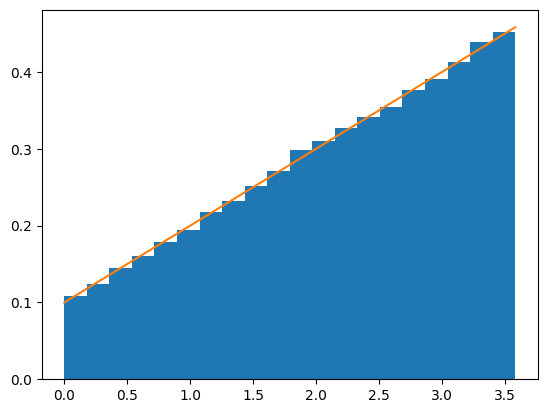

In [5]:
def random_nnDist(a,b,custDist,size=None, nControl=10**6):
    #genearte a list of size random samples, obeying the distribution custDist
    #suggests random samples between x0 and x1 and accepts the suggestion with probability custDist(x)
    #custDist noes not need to be normalized. Add this condition to increase performance. 
    #Best performance for max_{x in [x0,x1]} custDist(x) = 1
    samples=[]
    nLoop=0
    
    low = 0
    high = (np.sqrt(a**2 + 2*b) - a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples

def random_nnnDist(w,a,b,custDist,size=None, nControl=10**6):
    samples=[]
    nLoop=0
    
    low = w
    high = (np.sqrt(a**2 + 2*b*(1+a*w+b*w**2/2))-a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples


#call
a=0.1
b=0.1
def linDist(x, a, b):
    return a + b*x
samples=random_nnDist(a,b,custDist=linDist,size=100000)
#print(samples)

plt.hist(np.array(samples), density=True, bins = 20)

x = np.linspace(0, (np.sqrt(a**2 + 2*b) - a)/b, 1000)

plt.plot(x, np.array(linDist(x, a, b)))

In [111]:
def fill_zeta_ij_matrix(size, nn_ind, nnn_ind, a, b, include_nnn=True):
    zeta_ij_vals = sparse.lil_matrix((size, size))
    for ind in range(size):
        
        #Filling nn bonds
        adj_ind_array = np.array(nn_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]
        
        zeta_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.array(random_nnDist(a/3.0, b/3.0, custDist=linDist, size=len(upper_ind))))
        
        if include_nnn:
            #Filling nnn bonds
            w = (np.sqrt((a/3)**2 + 2*(b/3)) - a/3)/(b/3)
            adj_ind_array = np.array(nnn_ind[ind])
            upper_ind = adj_ind_array[adj_ind_array>ind]

            zeta_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.exp(random_nnnDist(w, a/6.0, b/6.0, custDist=linDist, size=len(upper_ind))))

    return zeta_ij_vals + zeta_ij_vals.T

def chunk_deleter(ind_array, size):
    eye_diag = np.ones(size)
    eye_diag[ind_array] = 0
    return sparse.diags(eye_diag)

def resparse(spr_mat, size, tol):
    i_ind, j_ind, vals = sparse.find(spr_mat)
    mask = vals>tol
    i_new, j_new, val_new = i_ind[mask], j_ind[mask], vals[mask]
    
    return sparse.csr_matrix((val_new, (i_new, j_new)), shape=(size, size))

0

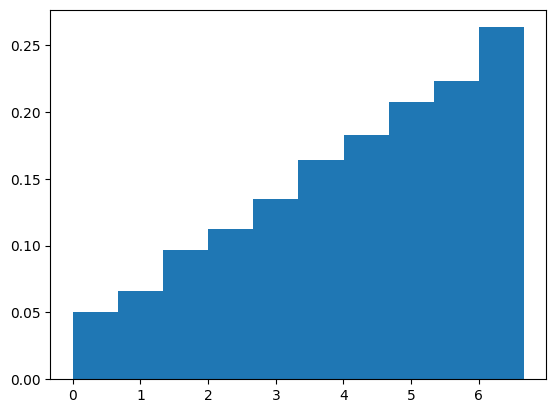

In [104]:
zeta_ij_vals = fill_zeta_ij_matrix(L*L, nn_ind, nnn_ind, a, b, include_nnn=False)

plt.hist(sparse.find(zeta_ij_vals)[2], density=True)

(sparse.find(zeta_ij_vals)[2]<0).sum()

In [6]:
def update_adjacency_zeta_ij(adj_ind, i, j):
    #Updates adjaceny set of i with that of j
    #Also deletes index from the adjacency list of other indices
    adj_i = adj_ind[i]
    adj_j = adj_ind[j]
    
    adj_i_new = list(set(adj_i+adj_j))
    adj_i_new = list(set(adj_i_new)-set([i, j]))
    adj_ind[i] = adj_i_new
    adj_ind[j] = []
    
    for k in adj_i_new:
        adj_ind[k] = list(set(adj_ind[k]+[i])-set([j]))
        
    return None

def update_adjacency_beta(adj_ind, i):
    #Updates adjacency set of every element in adj(i) with adj(i)
    #Also deletes index i from adj(k) for all k in adj(i)
    adj_i = adj_ind[i]
    
    for k in adj_ind[i]:
        adj_ind[k] = list(set(adj_ind[k]+adj_i)-set([i]))
        
    adj_ind[i] = []
    return None
    

In [123]:
class log_system:
    
    def __init__(self, size, adj_ind, zeta_ij_vals, beta_vals):
        
        self.size = size
        self.adj_ind = adj_ind
        self.zeta_ij_vals = zeta_ij_vals
        self.beta_vals = beta_vals
        
        self.Gamma_array = []
        self.Gamma_0 = min(beta_vals.min(), sparse.find(zeta_ij_vals)[2].min())
        self.Gamma = self.Gamma_0
        return None
    
    def decimate(self):
        beta_min, zeta_min = self.beta_vals[self.beta_vals>0].min(), sparse.find(self.zeta_ij_vals)[2].min()
        Gamma = min(beta_min, zeta_min)
        self.Gamma = Gamma
        self.Gamma_array.append(Gamma)
        if Gamma == zeta_min: self.zeta_decimation(Gamma)
        elif Gamma == beta_min: self.beta_decimation(Gamma)
        
        return None
    
    def zeta_decimation(self, Gamma):
        r_ind, c_ind, zeta_ij = sparse.find(self.zeta_ij_vals) 
        zeta_ind = np.where(zeta_ij == Gamma)[0][0]
        i, j = r_ind[zeta_ind], c_ind[zeta_ind]

        self.beta_vals[i] = self.beta_vals[i] + self.beta_vals[j]    
        self.beta_vals[j] = 0

        update_adjacency_zeta_ij(self.adj_ind, i, j)

        self.zeta_ij_vals[i,self.adj_ind[i]] = \
        (self.zeta_ij_vals[i, self.adj_ind[i]] + self.zeta_ij_vals[j, self.adj_ind[i]])/2
        
        
        self.zeta_ij_vals[self.adj_ind[i], i] = self.zeta_ij_vals[i,self.adj_ind[i]]

        eye = chunk_deleter([j], self.size)
        self.zeta_ij_vals = eye @ self.zeta_ij_vals @ eye
        return None
    
    def beta_decimation(self, Gamma):
        i = np.where(self.beta_vals == Gamma)[0][0]
        adj_i = self.adj_ind[i]

        #zeta_ij_new = np.outer(self.zeta_ij_vals[adj_i, i].toarray(),np.ones(len(adj_i))) 
        #zeta_ij_new = zeta_ij_new + zeta_ij_new.T
        
        zeta_ij_new = np.add.outer(self.zeta_ij_vals[adj_i, i].toarray()[:,0], self.zeta_ij_vals[adj_i, i].toarray()[:,0])

        self.zeta_ij_vals[adj_i, :][:, adj_i] = (zeta_ij_new + self.zeta_ij_vals[adj_i,:][:, adj_i])/2

        self.beta_vals[i] = 0

        eye = chunk_deleter([i], self.size)
        self.zeta_ij_vals = eye @ self.zeta_ij_vals @ eye

        update_adjacency_beta(self.adj_ind, i)
        return None
        

In [128]:
L = 50
a, b = 0.1, 0.105

ind_dict, adj_ind = triangle_lattice_dictionary(L)
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

zeta_ij_vals = fill_zeta_ij_matrix(L*L, nn_ind, nnn_ind, a, b, include_nnn=False)
beta_vals = np.random.exponential(size=L*L)

test = log_system(L*L, adj_ind, zeta_ij_vals,  beta_vals)


(0.0, 20.0)

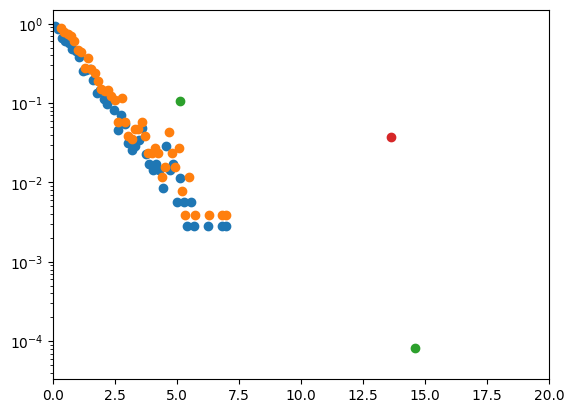

In [129]:
steps = 2400
check_list = np.array([0, 600, 1200, 1800, 2350])

for i in range(steps):
    test.decimate()
    #print(i)
    if i in check_list:
        beta_remain = test.beta_vals
        beta_remain = beta_remain[beta_remain!=0] 
        n,bins = np.histogram(beta_remain, density=True, bins = 50)
        width = bins[1]-bins[0]
        plt.scatter(bins[1:]-width/2, n)
        """
        zeta_remain = sparse.find(test.zeta_ij_vals)[2]
        n,bins = np.histogram(zeta_remain, density=True, bins = 50)
        width = bins[1]-bins[0]
        plt.scatter(bins[1:]-width/2, n)
        """
        
#plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 20)

In [7]:
from scipy import sparse
L = 4
ind_dict, adj_ind = square_lattice_dictionary(L)
a, b = (0.1, 0.1)

In [10]:


#fill_J_ij_matrix(L, adj_ind, a, b)
L, a, b = 100, 0.1, 0.1
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)
t = time.time()
J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b, include_nnn=False)
print(-t+time.time())

3.265859365463257


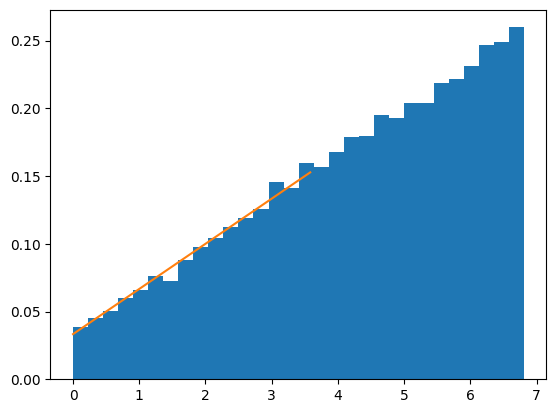

In [11]:
plt.hist(-np.log(sparse.find(J_ij_vals)[2]), density = 'True', bins=30)
x = np.linspace(0, (np.sqrt(a**2 + 2*b) - a)/b, 1000)

plt.plot(x, np.array(linDist(x, a/3, b/3)))

In [14]:
L = 30
steps = 600
runs = 1
#R0_array_sum = np.zeros(int(steps/50))

cluster_tracker = np.ones(L*L)

a_vals = np.array([0.1])#np.arange(0.05, 0.2, 0.02)
b_vals = np.array([0.105])#np.arange(0.1,0.3,0.03)

for run in range(runs):
    Gamma_array = np.zeros(shape=(len(a_vals), len(b_vals), steps))
    R0_array = []
    mu_array = []
    #R0_array_err = []

    t_total_Jij = 0
    t_total_h = 0

    for l, a in enumerate(a_vals):
        for m, b in enumerate(b_vals):

            ind_dict, adj_ind = triangle_lattice_dictionary(L)
            nn_ind = triangle_nn_indices(L)
            nnn_ind = triangle_nnn_indices(L)

            J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
            h_vals = np.exp(-np.random.exponential(size=L*L))

            Omega_0 = max(h_vals.max(), J_ij_vals.max())
            for step in range(steps):

                if step%1000 == 0: print ("Step: "+str(step)+"/"+str(steps))
                Omega = max(h_vals.max(), J_ij_vals.max())
                Gamma_array[l,m,step] = (np.log(Omega_0/Omega))
                #J_ij_vals = resparse(J_ij_vals, L*L, Omega*(1-steps/(L*L)))

                if Omega == J_ij_vals.max():
                    """
                    Strongest term is an Ising coupling -> Renormalizes to a field given by h_i * h_j/J_ij
                    Delete one of the elements (say h_i), shortening h_vals
                    Update adjacency of j to include both adj(i) and adj(j)
                    Set new Jnew_jk = max (J_jk, J_ik)
                    Delete the corresponding row and column in J_ij (J_i* and J*i) and set the adjacency of i to []
                    """
                    t0 = time.time()
                    r_ind, c_ind, J_ij = sparse.find(J_ij_vals) 
                    J_ind = np.where(J_ij == Omega)[0][0]
                    i, j = r_ind[J_ind], c_ind[J_ind]

                    h_vals[i] = h_vals[i]*h_vals[j]/Omega    #Might need to include a factor of 2 here since we are symmetrizing later
                    h_vals[j] = 0

                    update_adjacency_J_ij(adj_ind, i, j)

                    J_ij_vals[i,adj_ind[i]] = J_ij_vals[i, adj_ind[i]].maximum(J_ij_vals[j, adj_ind[i]])
                    J_ij_vals[adj_ind[i], i] = J_ij_vals[i,adj_ind[i]]

                    eye = chunk_deleter([j], L*L)
                    J_ij_vals = eye @ J_ij_vals @ eye
                    t_total_Jij += time.time()-t0
                    cluster_tracker[i] += cluster_tracker[j]
                    cluster_tracker[j] = 0
                elif Omega == h_vals.max():
                    """
                    """
                    t0 = time.time()
                    i = np.where(h_vals == h_vals.max())[0][0]
                    adj_i = adj_ind[i]
                    J_ij_new = J_ij_vals[adj_i, i] @J_ij_vals[i, adj_i]/Omega

                    J_ij_vals[adj_i, :][:, adj_i] = J_ij_new.maximum(J_ij_vals[adj_i,:][:, adj_i])

                    h_vals[i] = 0

                    eye = chunk_deleter([i], L*L)
                    J_ij_vals = eye @ J_ij_vals @ eye

                    update_adjacency_h(adj_ind, i)
                    t_total_h += time.time()-t0
                if step%20 == 0:
                    h_vals_remain = h_vals[h_vals!=0]
                    cluster_moments = cluster_tracker[cluster_tracker!=0]
                    n,bins = np.histogram(-np.log(h_vals_remain/Omega), density=True, bins = 40)

                    width = bins[1]-bins[0]
                    popt, pcov = curve_fit(exponential_dist_norm, bins[1:]-width/2, n)
                    R0_array.append(popt[0])
                    mu_array.append(cluster_moments.mean())
                    #R0_array_err.append(pcov[0][0])
    #R0_array_sum += np.array(R0_array)

Step: 0/600


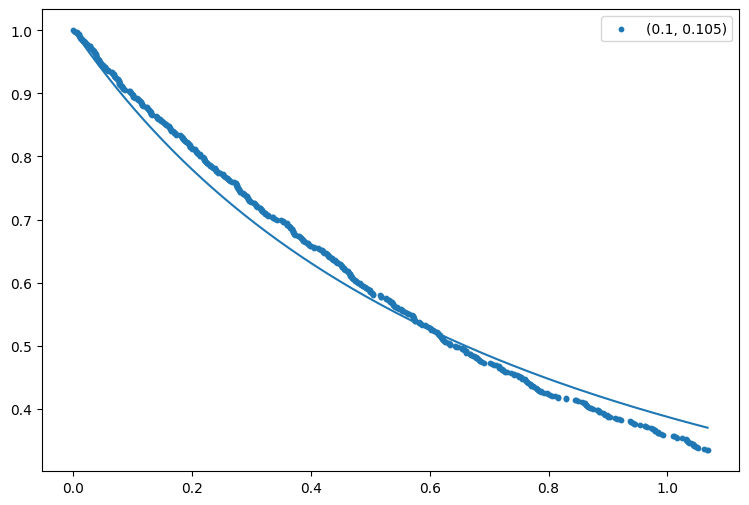

In [15]:
n_array = (- np.arange(steps)+(L*L))/(L*L)
plt.figure(figsize=(9, 6))
for l, a in enumerate(a_vals):
    for m, b in enumerate(b_vals):
        plt.scatter(Gamma_array[l,m,:],  n_array, s=10, label="("+str(a)+', '+str(b)+")")
plt.plot(Gamma_array[0,0,:], (Gamma_array[0,0,:]+1)**(-1.368))



plt.legend()
#plt.xlim(0, 10)

[0.14192157 2.58839875]
0.28384313588102855


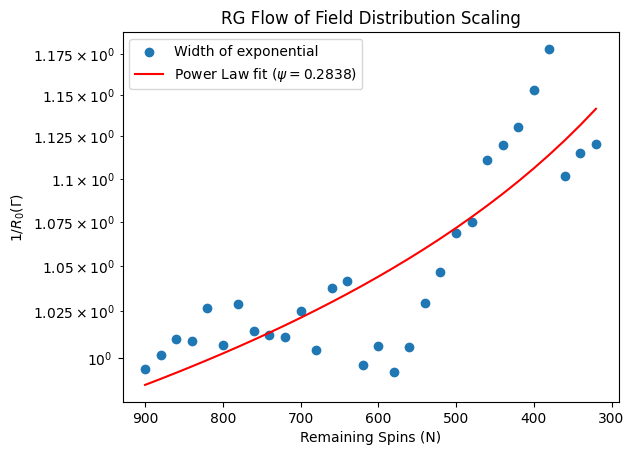

In [16]:
x = L*L - np.arange(len(R0_array))*20.0
y = runs/np.array(R0_array)

plt.scatter(x, y, label='Width of exponential')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x, y)
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0]*2, 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
#plt.ylim(0, 1.5)

[-0.05362113  0.36462037]


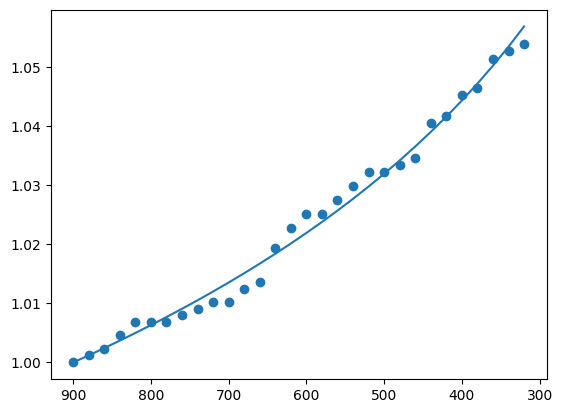

In [17]:
log_x = np.log(x)
log_mu = np.log(np.array(mu_array))

plt.scatter(np.exp(log_x), np.exp(log_mu))
plt.gca().invert_xaxis()

popt, pcov = curve_fit(linear_fit,log_x , log_mu)

plt.plot(np.exp(log_x), np.exp(linear_fit(log_x, *popt)))
#plt.xscale('log')
#plt.yscale('log')
print(popt)

In [25]:
popt, pcov = curve_fit(power_law_scale, x[-150:], 1/np.array(R0_array)[-150:])
print(popt)
print(popt[0]*2)

[8.28500272e-01 8.51654087e+03]
1.6570005448906635


C:\Users\tsgau\AppData\Local\Temp\ipykernel_13980\2578980702.py:41: RuntimeWarning: overflow encountered in power
  return scale*x**(-a)


In [96]:
print(t_total_Jij)
print(t_total_h)

510.70387864112854
378.47939229011536


In [203]:
popt, pcov = curve_fit(power_law, Gamma_array[0,0,:]+1, n_array)
popt

array([1.36841463])

[1.48256195 0.80559606]


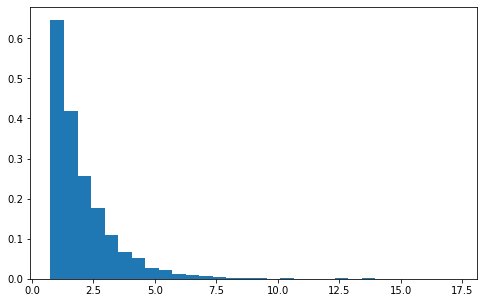

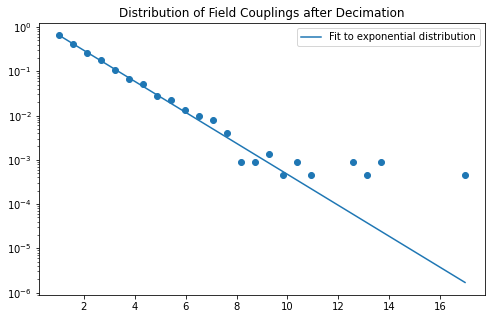

In [134]:
h_vals_remain = h_vals[h_vals!=0]
plt.figure(figsize=(8,5))
n,bins, pacthes = plt.hist(-np.log(h_vals_remain), density=True, bins = 30)

width = bins[1]-bins[0]

plt.figure(figsize=(8,5))
x_data = bins[1:]-width/2
popt, pcov = curve_fit(exponential_dist,x_data, n)

plt.plot(x_data, exponential_dist(x_data, *popt), label='Fit to exponential distribution')
plt.scatter(x_data, n)
plt.title("Distribution of Field Couplings after Decimation")
plt.yscale('log')
plt.legend()
print(popt)

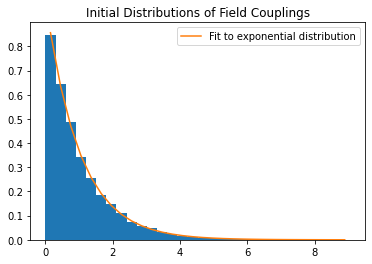

In [112]:
h_vals_ini = np.exp(-np.random.exponential(size=L*L))
n,bins, pacthes = plt.hist(-np.log(h_vals_ini), density=True, bins = 30)

width = bins[1]-bins[0]


x_data = bins[1:]-width/2
popt, pcov = curve_fit(exponential_dist,x_data, n)

plt.plot(x_data, exponential_dist(x_data, *popt), label='Fit to exponential distribution')
plt.title("Initial Distributions of Field Couplings")
plt.legend()

0.36549707602339176

[1, 2, 3, 4]